In [1]:
import os
import pickle
import fsps
import numpy as np 
import astropy.units as u
from astropy import units as U 
from astropy.cosmology import Planck13
# -- plotting --
import matplotlib as mpl 
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import scipy.interpolate as interpolate
%matplotlib inline

In [2]:
dir_dat = '../gqp_mc/dat/'

In [3]:
# read in lookback time bins (binning for SFH)
t_lookback = np.loadtxt(dir_dat+'sfh_t_int.txt')

In [4]:
# read in SFH and ZH bases
nmf_sfh_basis = np.loadtxt(dir_dat+'NMF_2basis_SFH_components_nowgt_lin_Nc4.txt')
nmf_zh_basis = np.loadtxt(dir_dat+'NMF_2basis_Z_components_nowgt_lin_Nc2.txt')
Nbins = nmf_sfh_basis.shape[1]
Ncomp_sfh = nmf_sfh_basis.shape[0]
Ncomp_zh = nmf_zh_basis.shape[0]
print("%i bins" % Nbins)
print("SFH basis has %i components" % Ncomp_sfh)
print("ZH basis has %i components" % Ncomp_zh)

# Make interpolation functions for SFH and ZH basis functions
sfh_basis = [interpolate.InterpolatedUnivariateSpline(max(t_lookback) - t_lookback, nmf_sfh_basis[i], k = 1) for i in range(Ncomp_sfh)]
zh_basis = [interpolate.InterpolatedUnivariateSpline(max(t_lookback) - t_lookback, nmf_zh_basis[i], k = 1) for i in range(Ncomp_zh)]

50 bins
SFH basis has 4 components
ZH basis has 2 components


In [15]:
fsps.__version__

'0.3.0'

In [6]:
# initalize fsps object
ssp = fsps.StellarPopulation(
    zcontinuous=1, # SSPs are interpolated to the value of logzsol before the spectra and magnitudes are computed
    sfh=0, # single SSP
    imf_type=1, # chabrier
    dust_type=2 # Calzetti (2000) 
    )

In [7]:
print('%s isochrone library' % ssp.isoc_library)
print('%s spectral library' % ssp.spec_library) 

b'mist' isochrone library
b'miles' spectral library


In [8]:
def sspLum(theta): 
    ''' FSPS wrapper that deals with NMF SFH and ZH basis and other parameters. 
    
    :param theta: 
        numpy array that specifies parameters. 
        Indices 0 to Ncomp_sfh-1 specifies the SFH basis parameters. 
        Indices Ncomp_sfh to Ncomp_sfh + Ncomp_zh specifies the ZH basis parameters.
        Index -1 specifes tau_ISM (dust) 
        
    :return wave_rest
        rest-frame wavelength grid provided by FSPS
        
    :return lum_ssp:
        luminosity in uints of Lsun/AA of ssp. This can be converted to observed flux 
        of units erg/s/cm^2/Angstrom by multiplying x Lsun/(4pi dlum^2)/(1+z)
    '''
    theta_sfh = theta[:Ncomp_sfh]
    theta_zh = theta[Ncomp_sfh:Ncomp_sfh+Ncomp_zh]
    theta_dust = theta[-2] # dust parameter
    t_univ = theta[-1]
    
    # Array of times from 0 - t_univ
    t = np.linspace(0, t_univ, 50)

    # Convert to ages
    t_age = max(t) - t + 1e-8

    # Compute SFH and ZH
    sfh = np.sum(np.array([theta_sfh[i]*sfh_basis[i](t)/np.trapz(sfh_basis[i](t), t) for i in range(Ncomp_sfh)]), axis = 0)
    zh = np.sum(np.array([theta_zh[i]*zh_basis[i](t) for i in range(Ncomp_zh)]), axis = 0)
 
    for i, tage, m, z in zip(range(len(t_age)), t_age, sfh, zh): 
        if m <= 0: # no star formation in this bin 
            continue
        ssp.params['logzsol'] = np.log10(z/0.0190) # log(Z/Zsun)
        ssp.params['dust2'] = theta_dust 
        wave_rest, lum_i = ssp.get_spectrum(tage=tage, peraa=True) # in units of Lsun/AA
        if i == 0: 
            lum_ssp = np.zeros(len(wave_rest))
        lum_ssp += m * lum_i 
    return wave_rest, lum_ssp

In [9]:
zh_maxprior = 0.04 
zh_max = zh_maxprior/np.max(nmf_zh_basis)

In [10]:
prior_min = np.array([0, 0, 0, 0, 6.9e-5, 6.9e-5, 0, 9.5]) 
prior_max = np.array([50., 50., 50., 50., zh_max, zh_max, 3, 13.7])

print('prior lower bounds: ', prior_min)
print('prior upper bounds: ', prior_max)

prior lower bounds:  [0.0e+00 0.0e+00 0.0e+00 0.0e+00 6.9e-05 6.9e-05 0.0e+00 9.5e+00]
prior upper bounds:  [5.0000000e+01 5.0000000e+01 5.0000000e+01 5.0000000e+01 7.3282264e-03
 7.3282264e-03 3.0000000e+00 1.3700000e+01]


In [11]:
# Generate some random SED and sort out wavelength selection
theta = np.random.uniform(low=prior_min, high=prior_max)
print(theta)
wave, spec = sspLum(theta)
s = np.where((wave > 2.3e3)*(wave <= 1e4))[0] # wavelength selection

[1.74114501e+01 2.32805033e+01 3.91699069e+01 1.97139074e+01
 6.06761775e-03 3.41121785e-03 8.32786158e-01 1.15554035e+01]


/Users/ChangHoon/opt/anaconda3/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log10


In [12]:
# load in the bits required to reconstruct the emulator model: these will be global variables (for now)
f = open(dir_dat+'model_summary64.pkl', 'rb')
W, b, alpha, beta, pcas, pca_mean, pca_std, spec_mean, spec_std, theta_mean, theta_std, wave = pickle.load(f)
f.close()

In [13]:

# number of network layers
n_layers = len(W)

# Initial transform applied to input parameters (network is trained over a transformed parameter set)
def transform(theta):
    transformed_theta = np.copy(theta)
    transformed_theta[0] = np.sqrt(theta[0])
    transformed_theta[2] = np.sqrt(theta[2])
    return transformed_theta

# compute spectra given theta
def emulator(theta):
    
    # forward pass through the network
    act = []
    offset = np.log(np.sum(theta[0:4]))
    layers = [(transform(theta) - theta_mean)/theta_std]
    for i in range(n_layers-1):
        
        # linear network operation
        act.append(np.dot(layers[-1], W[i]) + b[i])

        # pass through activation function
        layers.append((beta[i] + (1.-beta[i])*1./(1.+np.exp(-alpha[i]*act[-1])))*act[-1])

    # final (linear) layer -> (normalized) PCA coefficients
    layers.append(np.dot(layers[-1], W[-1]) + b[-1])

    # rescale PCA coefficients, multiply out PCA basis -> normalized spectrum, shift and re-scale spectrum -> output spectrum
    return np.dot(layers[-1]*pca_std + pca_mean, pcas)*spec_std + spec_mean + offset

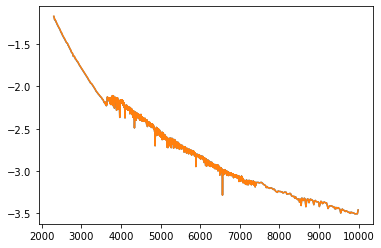

In [14]:
# plot emulated spectrum
spectrum = emulator(theta)
plt.plot(wave, spectrum)
plt.plot(wave, np.log(spec[s]))
plt.show()

In [14]:
np.save('_theta.npy', theta)
np.save('fsps_sspLum.npy', np.array([wave, spec[s]]))